In [187]:
from gekko import brain
import struct
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pickle

In [188]:
# Get data from binary file

In [189]:
# Get field nodes
file = open("D:/Documents/RLUtilities/assets/soccar/soccar_navigation_nodes.bin",
            "rb")
xd = []
yd = []
zd = []
byte = file.read(4)
while(byte):
    xd.append(list(struct.unpack('f', byte)))
    byte = file.read(4)
    yd.append(list(struct.unpack('f', byte)))
    byte = file.read(4)
    zd.append(list(struct.unpack('f', byte)))
    byte = file.read(4)

In [190]:
#Get field node normals
file = open("D:/Documents/RLUtilities/assets/soccar/soccar_navigation_normals.bin",
            "rb")
xnd = []
ynd = []
znd = []
byte = file.read(4)
while(byte):
    xnd.append(list(struct.unpack('f', byte)))
    byte = file.read(4)
    ynd.append(list(struct.unpack('f', byte)))
    byte = file.read(4)
    znd.append(list(struct.unpack('f', byte)))
    byte = file.read(4)

In [191]:
len(xd), len(yd), len(zd), len(xnd), len(ynd), len(znd)

(12115, 12115, 12115, 12115, 12115, 12115)

In [192]:
# setup input and output matricies
# dim(axis) 0 is input layer size (3), and dim(axis) 1 is #datasets
# Transpose since vector comes in with axis 0 the data sets
x = np.asarray(xd).T
y = np.asarray(yd).T
z = np.asarray(zd).T
xn = np.asarray(xnd).T
yn = np.asarray(ynd).T
zn = np.asarray(znd).T
x.shape, y.shape, z.shape, xn.shape, yn.shape, zn.shape

((1, 12115), (1, 12115), (1, 12115), (1, 12115), (1, 12115), (1, 12115))

In [193]:
input = np.concatenate((x,y,z), axis = 0)
output = np.concatenate((xn, yn, zn), axis = 0)
input.shape, output.shape

((3, 12115), (3, 12115))

In [194]:
# Remove x y z < 0
# i = input[:, np.all(input > 0, axis=0)]
# o = output[:, np.all(input >0, axis=0)]
i = input
o = output
np.all(i>0), i.shape, o.shape

(False, (3, 12115), (3, 12115))

In [195]:
np.sum(np.linalg.norm(o, axis=0)-1)

-2.1711470729046667e-06

In [196]:
# Shuffle array so that the first 1000 give hopefully good cover on the manifold
def shuffle(node, norm):
    n = len(node[0])
    grid = np.zeros(n, dtype=np.int32)
    for i in range(0,len(grid)): grid[i] = i
    np.random.shuffle(grid)
    print('grid: ', grid)
    return node[:,grid], norm[:,grid]
i,o = shuffle(i, o)
print('i: ', i, ' | o: ', o)

grid:  [ 4271 10638 11362 ...  1158 11348 10012]
i:  [[-1280.         -2815.94873047  3455.97802734 ... -2048.
   3705.98828125 -4067.75366211]
 [ 1536.          4351.96875      896.         ... -2304.
    384.          1792.        ]
 [   17.          2031.          2031.         ...    17.
   2019.62207031  1658.3614502 ]]  | o:  [[ 0.00000000e+00  4.12410162e-02 -3.95232923e-02 ...  0.00000000e+00
  -2.02443764e-01  9.86843169e-01]
 [ 0.00000000e+00 -4.12396975e-02  1.03025748e-07 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.00000000e+00 -9.98297811e-01 -9.99218643e-01 ...  1.00000000e+00
  -9.79293883e-01 -1.61680207e-01]]


In [197]:
start = 0
stop = 500
ip1=i[:,start:stop]
op1 = o[:,start:stop]
ip1.shape, op1.shape

((3, 500), (3, 500))

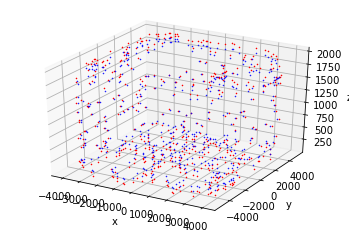

In [198]:
#Initialize 3d figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
Axes3D.plot(ax, ip1[0], ip1[1], ip1[2], 'r*', markersize=1)
Axes3D.plot(ax, ip1[0] + op1[0]*100, ip1[1] + op1[1]*100, ip1[2] + op1[2]*100, 'b.', markersize=1)


In [199]:
###---------------------------------###############
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout, Lambda
from keras.losses import MeanSquaredError, cosine_similarity
from keras.optimizers import SGD, Adam
from keras.utils import normalize
from livelossplot import PlotLossesKeras
import keras.backend as kb
import keras


In [200]:
kb.epsilon()

1e-07

In [276]:
# normaliZed root mean square error
def nrmse_loss(ya, yp): # y actual, y predicted
    ypn = yp / (kb.epsilon() + kb.sqrt(kb.sum(kb.square(yp))))
    yan = ya / (kb.epsilon() + kb.sqrt(kb.sum(kb.square(ya))))
    minus_ypn = 0.0 - yan
    mse = kb.add(yan, minus_ypn)
    return mse

In [279]:
# Fitting params
epochs=1000

# NN creation
model = Sequential()
# model.add(BatchNormalization())
model.add(Dense(100, input_dim=3, activation = "sigmoid"))
model.add(Dropout(0.2))
model.add(Dense(100, activation = "sigmoid"))
model.add(Dropout(0.2))
model.add(Dense(100, activation = "sigmoid"))
# model.add(Dropout(0.2))
model.add(Dense(3, activation="linear"))
model.compile(loss='mse', optimizer=SGD(nesterov=True, momentum =0.1, lr=0.01, decay = 1e-4/epochs), metrics=['mse', 'accuracy'])

In [280]:
# Train the network
history = model.fit(i.T, o.T, epochs=epochs, batch_size=1000)

Epoch 1/1000
12115/12115 [==============================] - 0s 15us/step - loss: 0.4713 - mse: 0.4713 - accuracy: 0.2749
Epoch 2/1000
12115/12115 [==============================] - 0s 4us/step - loss: 0.3414 - mse: 0.3414 - accuracy: 0.4223
Epoch 3/1000
12115/12115 [==============================] - 0s 5us/step - loss: 0.3394 - mse: 0.3394 - accuracy: 0.4264
Epoch 4/1000
12115/12115 [==============================] - 0s 5us/step - loss: 0.3374 - mse: 0.3374 - accuracy: 0.4365
Epoch 5/1000
12115/12115 [==============================] - 0s 4us/step - loss: 0.3352 - mse: 0.3352 - accuracy: 0.4380
Epoch 6/1000
12115/12115 [==============================] - 0s 5us/step - loss: 0.3344 - mse: 0.3344 - accuracy: 0.4332
Epoch 7/1000
12115/12115 [==============================] - 0s 5us/step - loss: 0.3331 - mse: 0.3331 - accuracy: 0.4397
Epoch 8/1000
12115/12115 [==============================] - 0s 4us/step - loss: 0.3309 - mse: 0.3309 - accuracy: 0.4414
Epoch 9/1000
12115/12115 [=============

12115/12115 [==============================] - 0s 5us/step - loss: 0.2749 - mse: 0.2749 - accuracy: 0.5428
Epoch 69/1000
12115/12115 [==============================] - 0s 5us/step - loss: 0.2745 - mse: 0.2745 - accuracy: 0.5405
Epoch 70/1000
12115/12115 [==============================] - 0s 5us/step - loss: 0.2733 - mse: 0.2733 - accuracy: 0.5444
Epoch 71/1000
12115/12115 [==============================] - 0s 5us/step - loss: 0.2730 - mse: 0.2730 - accuracy: 0.5457
Epoch 72/1000
12115/12115 [==============================] - 0s 5us/step - loss: 0.2718 - mse: 0.2718 - accuracy: 0.5520
Epoch 73/1000
12115/12115 [==============================] - 0s 5us/step - loss: 0.2715 - mse: 0.2715 - accuracy: 0.5496
Epoch 74/1000
12115/12115 [==============================] - 0s 5us/step - loss: 0.2710 - mse: 0.2710 - accuracy: 0.5474
Epoch 75/1000
12115/12115 [==============================] - 0s 5us/step - loss: 0.2707 - mse: 0.2707 - accuracy: 0.5469
Epoch 76/1000
12115/12115 [===================

12115/12115 [==============================] - 0s 5us/step - loss: 0.2257 - mse: 0.2257 - accuracy: 0.6485
Epoch 136/1000
12115/12115 [==============================] - 0s 5us/step - loss: 0.2250 - mse: 0.2250 - accuracy: 0.6438
Epoch 137/1000
12115/12115 [==============================] - 0s 5us/step - loss: 0.2234 - mse: 0.2234 - accuracy: 0.6499
Epoch 138/1000
12115/12115 [==============================] - 0s 4us/step - loss: 0.2222 - mse: 0.2222 - accuracy: 0.6489
Epoch 139/1000
12115/12115 [==============================] - 0s 5us/step - loss: 0.2217 - mse: 0.2217 - accuracy: 0.6601
Epoch 140/1000
12115/12115 [==============================] - 0s 5us/step - loss: 0.2208 - mse: 0.2208 - accuracy: 0.6556
Epoch 141/1000
12115/12115 [==============================] - 0s 6us/step - loss: 0.2203 - mse: 0.2203 - accuracy: 0.6551
Epoch 142/1000
12115/12115 [==============================] - 0s 5us/step - loss: 0.2190 - mse: 0.2190 - accuracy: 0.6602
Epoch 143/1000
12115/12115 [===========

12115/12115 [==============================] - 0s 5us/step - loss: 0.1575 - mse: 0.1575 - accuracy: 0.7588
Epoch 203/1000
12115/12115 [==============================] - 0s 5us/step - loss: 0.1569 - mse: 0.1569 - accuracy: 0.7594
Epoch 204/1000
12115/12115 [==============================] - 0s 8us/step - loss: 0.1559 - mse: 0.1559 - accuracy: 0.7663
Epoch 205/1000
12115/12115 [==============================] - 0s 6us/step - loss: 0.1559 - mse: 0.1559 - accuracy: 0.7612
Epoch 206/1000
12115/12115 [==============================] - 0s 5us/step - loss: 0.1540 - mse: 0.1540 - accuracy: 0.7612
Epoch 207/1000
12115/12115 [==============================] - 0s 8us/step - loss: 0.1525 - mse: 0.1525 - accuracy: 0.7598
Epoch 208/1000
12115/12115 [==============================] - 0s 6us/step - loss: 0.1517 - mse: 0.1517 - accuracy: 0.7650
Epoch 209/1000
12115/12115 [==============================] - 0s 7us/step - loss: 0.1508 - mse: 0.1508 - accuracy: 0.7681
Epoch 210/1000
12115/12115 [===========

12115/12115 [==============================] - 0s 5us/step - loss: 0.1260 - mse: 0.1260 - accuracy: 0.7998
Epoch 270/1000
12115/12115 [==============================] - 0s 7us/step - loss: 0.1247 - mse: 0.1247 - accuracy: 0.7961
Epoch 271/1000
12115/12115 [==============================] - 0s 6us/step - loss: 0.1238 - mse: 0.1238 - accuracy: 0.7983
Epoch 272/1000
12115/12115 [==============================] - 0s 5us/step - loss: 0.1236 - mse: 0.1236 - accuracy: 0.7982
Epoch 273/1000
12115/12115 [==============================] - 0s 5us/step - loss: 0.1233 - mse: 0.1233 - accuracy: 0.8030
Epoch 274/1000
12115/12115 [==============================] - 0s 6us/step - loss: 0.1239 - mse: 0.1239 - accuracy: 0.8014
Epoch 275/1000
12115/12115 [==============================] - 0s 6us/step - loss: 0.1239 - mse: 0.1239 - accuracy: 0.7963
Epoch 276/1000
12115/12115 [==============================] - 0s 5us/step - loss: 0.1242 - mse: 0.1242 - accuracy: 0.7972
Epoch 277/1000
12115/12115 [===========

12115/12115 [==============================] - 0s 6us/step - loss: 0.1157 - mse: 0.1157 - accuracy: 0.8142
Epoch 336/1000
12115/12115 [==============================] - 0s 8us/step - loss: 0.1170 - mse: 0.1170 - accuracy: 0.8082
Epoch 337/1000
12115/12115 [==============================] - 0s 5us/step - loss: 0.1155 - mse: 0.1155 - accuracy: 0.8138
Epoch 338/1000
12115/12115 [==============================] - 0s 5us/step - loss: 0.1158 - mse: 0.1158 - accuracy: 0.8125
Epoch 339/1000
12115/12115 [==============================] - 0s 7us/step - loss: 0.1148 - mse: 0.1148 - accuracy: 0.8079
Epoch 340/1000
12115/12115 [==============================] - 0s 6us/step - loss: 0.1162 - mse: 0.1162 - accuracy: 0.8158
Epoch 341/1000
12115/12115 [==============================] - 0s 7us/step - loss: 0.1164 - mse: 0.1164 - accuracy: 0.8111
Epoch 342/1000
12115/12115 [==============================] - 0s 7us/step - loss: 0.1159 - mse: 0.1159 - accuracy: 0.8131
Epoch 343/1000
12115/12115 [===========

12115/12115 [==============================] - 0s 5us/step - loss: 0.1096 - mse: 0.1096 - accuracy: 0.8196
Epoch 403/1000
12115/12115 [==============================] - 0s 7us/step - loss: 0.1092 - mse: 0.1092 - accuracy: 0.8224
Epoch 404/1000
12115/12115 [==============================] - 0s 6us/step - loss: 0.1097 - mse: 0.1097 - accuracy: 0.8206
Epoch 405/1000
12115/12115 [==============================] - 0s 5us/step - loss: 0.1097 - mse: 0.1097 - accuracy: 0.8226
Epoch 406/1000
12115/12115 [==============================] - 0s 6us/step - loss: 0.1108 - mse: 0.1108 - accuracy: 0.8171
Epoch 407/1000
12115/12115 [==============================] - 0s 6us/step - loss: 0.1103 - mse: 0.1103 - accuracy: 0.8247
Epoch 408/1000
12115/12115 [==============================] - 0s 5us/step - loss: 0.1097 - mse: 0.1097 - accuracy: 0.8240
Epoch 409/1000
12115/12115 [==============================] - 0s 5us/step - loss: 0.1103 - mse: 0.1103 - accuracy: 0.8133
Epoch 410/1000
12115/12115 [===========

12115/12115 [==============================] - 0s 5us/step - loss: 0.1062 - mse: 0.1062 - accuracy: 0.8281
Epoch 470/1000
12115/12115 [==============================] - 0s 6us/step - loss: 0.1057 - mse: 0.1057 - accuracy: 0.8259
Epoch 471/1000
12115/12115 [==============================] - 0s 6us/step - loss: 0.1053 - mse: 0.1053 - accuracy: 0.8248
Epoch 472/1000
12115/12115 [==============================] - 0s 5us/step - loss: 0.1057 - mse: 0.1057 - accuracy: 0.8231
Epoch 473/1000
12115/12115 [==============================] - 0s 5us/step - loss: 0.1049 - mse: 0.1049 - accuracy: 0.8245
Epoch 474/1000
12115/12115 [==============================] - 0s 7us/step - loss: 0.1066 - mse: 0.1066 - accuracy: 0.8230
Epoch 475/1000
12115/12115 [==============================] - 0s 5us/step - loss: 0.1052 - mse: 0.1052 - accuracy: 0.8267
Epoch 476/1000
12115/12115 [==============================] - 0s 5us/step - loss: 0.1050 - mse: 0.1050 - accuracy: 0.8228
Epoch 477/1000
12115/12115 [===========

12115/12115 [==============================] - 0s 5us/step - loss: 0.1018 - mse: 0.1018 - accuracy: 0.8305
Epoch 537/1000
12115/12115 [==============================] - 0s 7us/step - loss: 0.1013 - mse: 0.1013 - accuracy: 0.8358
Epoch 538/1000
12115/12115 [==============================] - 0s 5us/step - loss: 0.1010 - mse: 0.1010 - accuracy: 0.8310
Epoch 539/1000
12115/12115 [==============================] - 0s 5us/step - loss: 0.1020 - mse: 0.1020 - accuracy: 0.8333
Epoch 540/1000
12115/12115 [==============================] - 0s 7us/step - loss: 0.1024 - mse: 0.1024 - accuracy: 0.8301
Epoch 541/1000
12115/12115 [==============================] - 0s 6us/step - loss: 0.1020 - mse: 0.1020 - accuracy: 0.8294
Epoch 542/1000
12115/12115 [==============================] - 0s 5us/step - loss: 0.1015 - mse: 0.1015 - accuracy: 0.8295
Epoch 543/1000
12115/12115 [==============================] - 0s 7us/step - loss: 0.1021 - mse: 0.1021 - accuracy: 0.8318
Epoch 544/1000
12115/12115 [===========

12115/12115 [==============================] - 0s 6us/step - loss: 0.0999 - mse: 0.0999 - accuracy: 0.8362
Epoch 604/1000
12115/12115 [==============================] - 0s 5us/step - loss: 0.0990 - mse: 0.0990 - accuracy: 0.8337
Epoch 605/1000
12115/12115 [==============================] - 0s 4us/step - loss: 0.0995 - mse: 0.0995 - accuracy: 0.8319
Epoch 606/1000
12115/12115 [==============================] - 0s 8us/step - loss: 0.0995 - mse: 0.0995 - accuracy: 0.8362
Epoch 607/1000
12115/12115 [==============================] - 0s 6us/step - loss: 0.0989 - mse: 0.0989 - accuracy: 0.8353
Epoch 608/1000
12115/12115 [==============================] - 0s 5us/step - loss: 0.0991 - mse: 0.0991 - accuracy: 0.8373
Epoch 609/1000
12115/12115 [==============================] - 0s 6us/step - loss: 0.0993 - mse: 0.0993 - accuracy: 0.8322
Epoch 610/1000
12115/12115 [==============================] - 0s 6us/step - loss: 0.0985 - mse: 0.0985 - accuracy: 0.8307
Epoch 611/1000
12115/12115 [===========

12115/12115 [==============================] - 0s 5us/step - loss: 0.0971 - mse: 0.0971 - accuracy: 0.8417
Epoch 671/1000
12115/12115 [==============================] - 0s 7us/step - loss: 0.0969 - mse: 0.0969 - accuracy: 0.8316
Epoch 672/1000
12115/12115 [==============================] - 0s 6us/step - loss: 0.0969 - mse: 0.0969 - accuracy: 0.8418
Epoch 673/1000
12115/12115 [==============================] - 0s 5us/step - loss: 0.0975 - mse: 0.0975 - accuracy: 0.8396
Epoch 674/1000
12115/12115 [==============================] - 0s 5us/step - loss: 0.0972 - mse: 0.0972 - accuracy: 0.8343
Epoch 675/1000
12115/12115 [==============================] - 0s 8us/step - loss: 0.0977 - mse: 0.0977 - accuracy: 0.8313
Epoch 676/1000
12115/12115 [==============================] - 0s 5us/step - loss: 0.0966 - mse: 0.0966 - accuracy: 0.8353
Epoch 677/1000
12115/12115 [==============================] - 0s 5us/step - loss: 0.0965 - mse: 0.0965 - accuracy: 0.8382
Epoch 678/1000
12115/12115 [===========

12115/12115 [==============================] - 0s 7us/step - loss: 0.0946 - mse: 0.0946 - accuracy: 0.8356
Epoch 737/1000
12115/12115 [==============================] - 0s 6us/step - loss: 0.0952 - mse: 0.0952 - accuracy: 0.8395
Epoch 738/1000
12115/12115 [==============================] - 0s 5us/step - loss: 0.0951 - mse: 0.0951 - accuracy: 0.8379
Epoch 739/1000
12115/12115 [==============================] - 0s 5us/step - loss: 0.0951 - mse: 0.0951 - accuracy: 0.8353
Epoch 740/1000
12115/12115 [==============================] - 0s 7us/step - loss: 0.0949 - mse: 0.0949 - accuracy: 0.8376
Epoch 741/1000
12115/12115 [==============================] - 0s 5us/step - loss: 0.0948 - mse: 0.0948 - accuracy: 0.8362
Epoch 742/1000
12115/12115 [==============================] - 0s 5us/step - loss: 0.0946 - mse: 0.0946 - accuracy: 0.8376
Epoch 743/1000
12115/12115 [==============================] - 0s 7us/step - loss: 0.0947 - mse: 0.0947 - accuracy: 0.8360
Epoch 744/1000
12115/12115 [===========

12115/12115 [==============================] - 0s 6us/step - loss: 0.0933 - mse: 0.0933 - accuracy: 0.8404
Epoch 804/1000
12115/12115 [==============================] - 0s 5us/step - loss: 0.0927 - mse: 0.0927 - accuracy: 0.8406
Epoch 805/1000
12115/12115 [==============================] - 0s 5us/step - loss: 0.0937 - mse: 0.0937 - accuracy: 0.8390
Epoch 806/1000
12115/12115 [==============================] - 0s 7us/step - loss: 0.0927 - mse: 0.0927 - accuracy: 0.8403
Epoch 807/1000
12115/12115 [==============================] - 0s 5us/step - loss: 0.0924 - mse: 0.0924 - accuracy: 0.8427
Epoch 808/1000
12115/12115 [==============================] - 0s 5us/step - loss: 0.0930 - mse: 0.0930 - accuracy: 0.8412
Epoch 809/1000
12115/12115 [==============================] - 0s 7us/step - loss: 0.0926 - mse: 0.0926 - accuracy: 0.8388
Epoch 810/1000
12115/12115 [==============================] - 0s 6us/step - loss: 0.0932 - mse: 0.0932 - accuracy: 0.8394
Epoch 811/1000
12115/12115 [===========

12115/12115 [==============================] - 0s 8us/step - loss: 0.0911 - mse: 0.0911 - accuracy: 0.8458
Epoch 871/1000
12115/12115 [==============================] - 0s 5us/step - loss: 0.0920 - mse: 0.0920 - accuracy: 0.8380
Epoch 872/1000
12115/12115 [==============================] - 0s 6us/step - loss: 0.0919 - mse: 0.0919 - accuracy: 0.8357
Epoch 873/1000
12115/12115 [==============================] - 0s 6us/step - loss: 0.0915 - mse: 0.0915 - accuracy: 0.8402
Epoch 874/1000
12115/12115 [==============================] - 0s 5us/step - loss: 0.0918 - mse: 0.0918 - accuracy: 0.8377
Epoch 875/1000
12115/12115 [==============================] - 0s 5us/step - loss: 0.0909 - mse: 0.0909 - accuracy: 0.8391
Epoch 876/1000
12115/12115 [==============================] - 0s 7us/step - loss: 0.0911 - mse: 0.0911 - accuracy: 0.8376
Epoch 877/1000
12115/12115 [==============================] - 0s 5us/step - loss: 0.0912 - mse: 0.0912 - accuracy: 0.8429
Epoch 878/1000
12115/12115 [===========

12115/12115 [==============================] - 0s 4us/step - loss: 0.0898 - mse: 0.0898 - accuracy: 0.8414
Epoch 938/1000
12115/12115 [==============================] - 0s 5us/step - loss: 0.0896 - mse: 0.0896 - accuracy: 0.8442
Epoch 939/1000
12115/12115 [==============================] - 0s 6us/step - loss: 0.0899 - mse: 0.0899 - accuracy: 0.8410
Epoch 940/1000
12115/12115 [==============================] - 0s 6us/step - loss: 0.0898 - mse: 0.0898 - accuracy: 0.8436
Epoch 941/1000
12115/12115 [==============================] - 0s 5us/step - loss: 0.0894 - mse: 0.0894 - accuracy: 0.8432
Epoch 942/1000
12115/12115 [==============================] - 0s 5us/step - loss: 0.0900 - mse: 0.0900 - accuracy: 0.8424
Epoch 943/1000
12115/12115 [==============================] - 0s 8us/step - loss: 0.0895 - mse: 0.0895 - accuracy: 0.8447
Epoch 944/1000
12115/12115 [==============================] - 0s 5us/step - loss: 0.0900 - mse: 0.0900 - accuracy: 0.8394
Epoch 945/1000
12115/12115 [===========

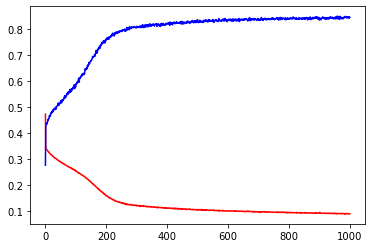

In [281]:
plt.plot(history.history['loss'], label='train', color='r')
# plt.plot(history.history['val_loss'], color='orange')
plt.plot(history.history['accuracy'], color='b')

In [231]:
# Save the Model
model.save("field_model")

In [232]:
# Get subset of data to test model fit
op = model.predict(i.T)

In [233]:
i[:, :10].shape, o[:,:10].shape

((3, 10), (3, 10))

In [234]:
err = op-o.T
np.var(err, axis=0), np.mean(err, axis=0)

(array([0.09916246, 0.07995992, 0.11167776]),
 array([-0.0034236 ,  0.00731333,  0.00524008]))

In [235]:
#Get a crude mean and variance from training data to output
depth=len(i[0,:])
ip = i[:, 0:depth]
oc = o[:, 0:depth]
op = model.predict(ip.T).T
op = op/np.linalg.norm(op, axis=0)
diff = op - oc
np.var(diff, axis=1), np.mean(diff, axis=1), ip.shape


(array([0.07891027, 0.05849003, 0.05340702]),
 array([-0.00710084,  0.00657922,  0.01004195]),
 (3, 12115))

In [236]:

def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    '''

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])


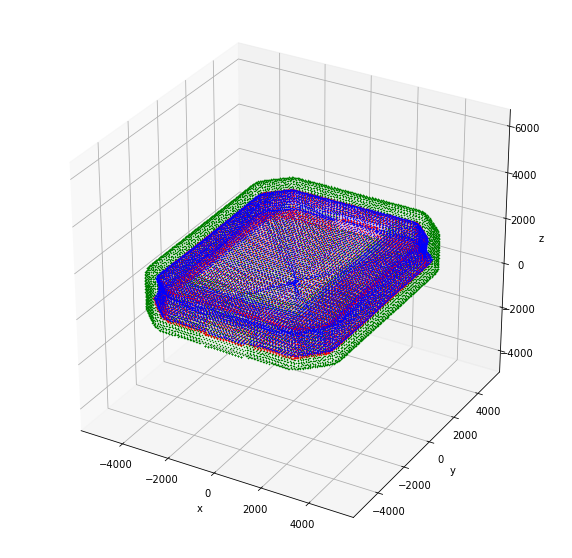

In [237]:
#PLOT the field nodes, the training set vectors and predicted vectors
#Initialize 3d figure
length = 500
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.axis('auto')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
Axes3D.plot(ax, ip[0], ip[1], ip[2], 'g*', markersize=1)
Axes3D.plot(ax, ip[0] + oc[0]*length, \
            ip[1] + oc[1]*length, \
            ip[2] + oc[2]*length, \
            'r.', markersize=1)
Axes3D.plot(ax, ip[0] + op[0]*length, \
            ip[1] + op[1]*length, \
            ip[2] + op[2]*length, \
            'b.', markersize=1)
# Axes3D.plot(ax, diff[0], diff[1], diff[2])
set_axes_equal(ax)

In [ ]:
# Plot outline of the field
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
Axes3D.plot(ax, i[0], i[1], i[2], 'g*', markersize=1)

In [ ]:
xt = np.expand_dims(np.linspace(-3000, -3100, 11), axis=1).T
yt = np.expand_dims(np.linspace(-4600, -4500, 11), axis=1).T
zt = np.expand_dims(np.ones(xt[0].shape)*17, axis=1).T
ii = np.concatenate((zt,yt,zt), axis = 0)
oe = model.predict(ii.T)
oe.shape, oe

In [ ]:
#Initialize 3d figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
Axes3D.plot(ax, diff[0], diff[1], diff[2], 'g*', markersize=3)
# Axes3D.plot(ax, ip[0] + oc[0]*100, ip[1] + oc[1]*100, ip[2] + oc[2]*100, 'r.', markersize=3)
# Axes3D.plot(ax, ip[0] + op[0]*100, ip[1] + op[1]*100, ip[2] + op[2]*100, 'b.', markersize=3)

In [ ]:
mask = x>-3000
xt = x[mask]
yt = y[mask]
zt = z[mask]
mask2 = inrange<-2900
xt = xt[mask2]
yt = yt[mask2]
zt = zt[mask2]
xt, yt, zt

In [ ]:
## Trying to use svd
